/var/folders/py/mxcg3q3x1tv_973vj59jz1_h0000gn/T/ipykernel_44086/2546024592.py:51: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  exp_x = np.exp(x)


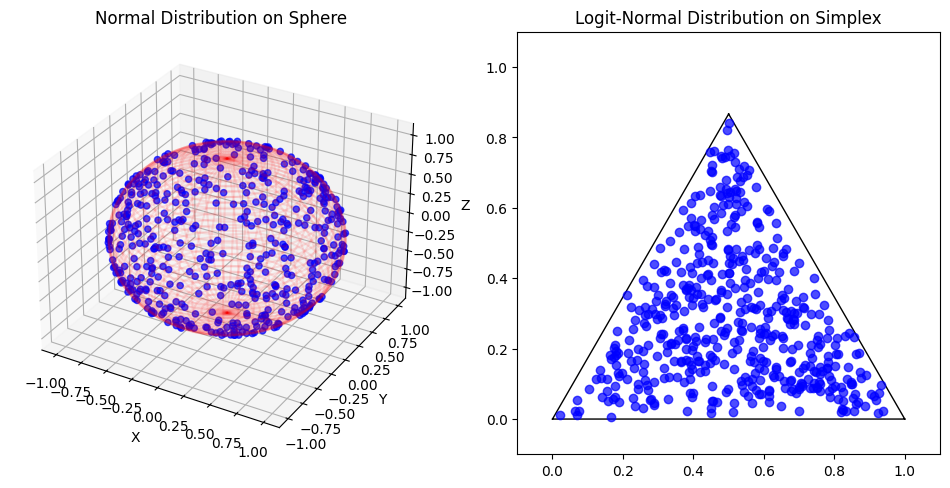

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.special

# Function to plot points on a 3D sphere
def plot_sphere_points(points, ax, title="Sphere Plot"):
    x, y, z = points.T
    ax.scatter(x, y, z, c='b', marker='o', alpha=0.7)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    # Draw a wireframe for better visualization of the sphere
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    xs = np.outer(np.cos(u), np.sin(v))
    ys = np.outer(np.sin(u), np.sin(v))
    zs = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(xs, ys, zs, color='r', alpha=0.1)

# Function to plot points on a 2D simplex (ternary plot)
def plot_simplex_points(points, ax, title="Simplex Plot"):
    from matplotlib.tri import Triangulation
    
    # Project points into 2D for the simplex (assuming a 3D simplex)
    tri = Triangulation([0, 1, 0.5], [0, 0, np.sqrt(3)/2])
    ax.triplot(tri, 'k-', lw=1)
    
    # Plot points in 2D using a barycentric projection
    def barycentric_proj(point):
        return [point[0] + point[1] / 2, np.sqrt(3) * point[1] / 2]
    
    projected_points = np.array([barycentric_proj(p) for p in points])
    ax.scatter(projected_points[:, 0], projected_points[:, 1], c='b', marker='o', alpha=0.7)
    ax.set_title(title)
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-0.1, 1.1])
    ax.set_aspect('equal')

# Sampling from spherical normal distribution
def sample_spherical_normal(n_samples, dim):
    x = torch.randn(n_samples, dim)
    x = x / torch.norm(x, dim=-1, keepdim=True)  # Normalize to the unit sphere
    return x.numpy()

# Sampling from logit-normal distribution mapped to simplex
def sample_logit_normal_simplex(n_samples, dim):
    x = torch.randn(n_samples, dim)
    exp_x = np.exp(x)
    simplex_points = exp_x / exp_x.sum(axis=1, keepdims=True)  # Softmax transformation
    return simplex_points

# Parameters
n_samples = 500
dim = 3  # 3D Sphere and 2D Simplex

# Generate samples
sphere_points = sample_spherical_normal(n_samples, dim)
simplex_points = sample_logit_normal_simplex(n_samples, dim)

# Plotting
fig = plt.figure(figsize=(12, 6))

# 3D plot of points on a sphere
ax_sphere = fig.add_subplot(121, projection='3d')
plot_sphere_points(sphere_points, ax_sphere, title="Normal Distribution on Sphere")

# 2D plot of points on the simplex
ax_simplex = fig.add_subplot(122)
plot_simplex_points(simplex_points, ax_simplex, title="Logit-Normal Distribution on Simplex")

plt.show()

/var/folders/py/mxcg3q3x1tv_973vj59jz1_h0000gn/T/ipykernel_44086/2871493324.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  simplex_points = sphere_to_simplex(torch.tensor(sphere_points))


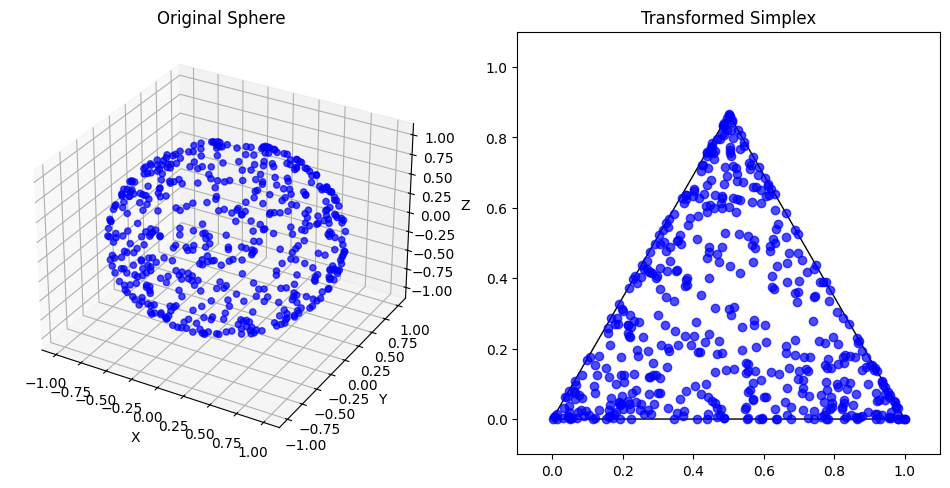

In [4]:
import torch
from torch.distributions import Transform, constraints
import numpy as np
import matplotlib.pyplot as plt

# Define a transform from the sphere to the simplex using softmax
class SphericalToSimplexTransform(Transform):
    domain = constraints.real
    codomain = constraints.simplex
    bijective = True
    sign = +1
    
    def __init__(self, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
    
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        # Apply softmax transformation to map spherical coordinates to simplex
        # exp_x = torch.exp(x)
        # return exp_x / (exp_x.sum(dim=-1, keepdim=True) + self.eps)
        return x.pow(2)
    
    def log_abs_det_jacobian(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        # Compute the log absolute determinant of the Jacobian for the softmax transformation
        logsumexp_x = torch.logsumexp(x, dim=-1)
        return x.sum(dim=-1) - logsumexp_x * x.size(-1)
    
# Define the inverse transform from simplex to sphere using logit
class SimplexToSphericalTransform(Transform):
    domain = constraints.simplex
    codomain = constraints.real
    bijective = True
    sign = -1
    
    def __init__(self, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
    
    def __call__(self, y: torch.Tensor) -> torch.Tensor:
        # Apply logit transformation to map from simplex to spherical coordinates
        y_clamped = torch.clamp(y, min=self.eps, max=1 - self.eps)
        return torch.log(y_clamped) - torch.log(1 - y_clamped.sum(dim=-1, keepdim=True))
    
    def log_abs_det_jacobian(self, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        # Compute the log absolute determinant of the Jacobian for the inverse transformation
        y_clamped = torch.clamp(y, min=self.eps, max=1 - self.eps)
        return -(torch.log(y_clamped) + torch.log(1 - y_clamped.sum(dim=-1, keepdim=True))).sum(dim=-1)

# Sampling from spherical normal distribution
def sample_spherical_normal(n_samples, dim):
    x = torch.randn(n_samples, dim)
    x = x / torch.norm(x, dim=-1, keepdim=True)  # Normalize to the unit sphere
    return x

# Plotting functions for sphere and simplex
def plot_3d_sphere(points, ax, title="Normal on Sphere"):
    x, y, z = points.T
    ax.scatter(x, y, z, c='b', marker='o', alpha=0.7)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)

def plot_simplex_points(points, ax, title="Logit-Normal on Simplex"):
    from matplotlib.tri import Triangulation
    tri = Triangulation([0, 1, 0.5], [0, 0, np.sqrt(3)/2])
    ax.triplot(tri, 'k-', lw=1)

    def barycentric_proj(p):
        return [p[0] + p[1] / 2, np.sqrt(3) * p[1] / 2]
    
    proj_points = np.array([barycentric_proj(p) for p in points])
    ax.scatter(proj_points[:, 0], proj_points[:, 1], c='b', alpha=0.7)
    ax.set_title(title)
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-0.1, 1.1])
    ax.set_aspect('equal')

# Parameters
n_samples = 500
dim = 3

# Generate points on a sphere
sphere_points = sample_spherical_normal(n_samples, dim)

# Create the transformation
sphere_to_simplex = SphericalToSimplexTransform()
simplex_to_sphere = SimplexToSphericalTransform()

# Transform sphere points to the simplex
simplex_points = sphere_to_simplex(torch.tensor(sphere_points))

# Transform back from simplex to spherical coordinates
reconstructed_sphere_points = simplex_to_sphere(simplex_points)

# Plotting
fig = plt.figure(figsize=(12, 6))

# 3D plot of the original sphere points
ax_sphere = fig.add_subplot(121, projection='3d')
plot_3d_sphere(sphere_points.numpy(), ax_sphere, title="Original Sphere")

# 2D plot of the transformed points on the simplex
ax_simplex = fig.add_subplot(122)
plot_simplex_points(simplex_points.numpy(), ax_simplex, title="Transformed Simplex")

plt.show()

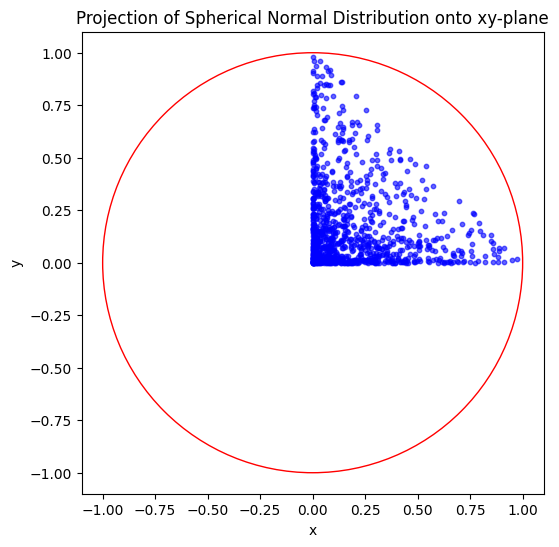

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define functions for logarithm map and exponential map
def logarithm_map(mu, x):
    """ Logarithm map from sphere to tangent space at mu. """
    theta = torch.acos(torch.clamp(torch.dot(mu, x), -1.0, 1.0))  # Angle between mu and x
    if theta == 0:
        return torch.zeros_like(x)
    return (x - mu * torch.cos(theta)) * (theta / torch.sin(theta))

def exponential_map(mu, v):
    """ Exponential map from tangent space to the sphere. """
    norm_v = torch.norm(v)
    if norm_v == 0:
        return mu
    return mu * torch.cos(norm_v) + (v / norm_v) * torch.sin(norm_v)

# Project points onto the xy-plane
def project_onto_xy_plane(x):
    """ Project points from the 3D sphere to the 2D xy-plane by discarding the z-coordinate. """
    return x[:, :2]

# Sampling from a spherical normal distribution
def sample_spherical_normal(mu, n_samples=1000, dim=3, scale=0.1):
    """ Sample points from a spherical normal distribution centered at mu. """
    tangent_samples = torch.randn(n_samples, dim - 1) * scale  # Tangent space sampling
    tangent_samples = torch.cat([tangent_samples, torch.zeros(n_samples, 1)], dim=-1)  # Last dimension is 0
    samples = torch.stack([exponential_map(mu, tangent_samples[i]) for i in range(n_samples)], dim=0)
    return samples

# Parameters
n_samples = 1000
dim = 3
mu = torch.tensor([0.0, 0.0, 1.0])  # North pole as the mean of the distribution
scale = 0.5  # Adjust scaling factor to spread points further from the north pole

# Generate samples from spherical normal distribution
samples = sample_spherical_normal(mu, n_samples=n_samples, dim=dim, scale=scale)

# Project the points onto the xy-plane
projected_points = project_onto_xy_plane(samples)

# Scatter plot of the projected points on the xy-plane
plt.figure(figsize=(6, 6))
plt.scatter(projected_points[:, 0].pow(2).numpy(), projected_points[:, 1].pow(2).numpy(), c='b', alpha=0.6, s=10)
plt.title('Projection of Spherical Normal Distribution onto xy-plane')
plt.xlabel('x')
plt.ylabel('y')

# Plot the disk boundary for reference (unit circle on the xy-plane)
disk = plt.Circle((0, 0), 1, color='r', fill=False)
plt.gca().add_artist(disk)

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

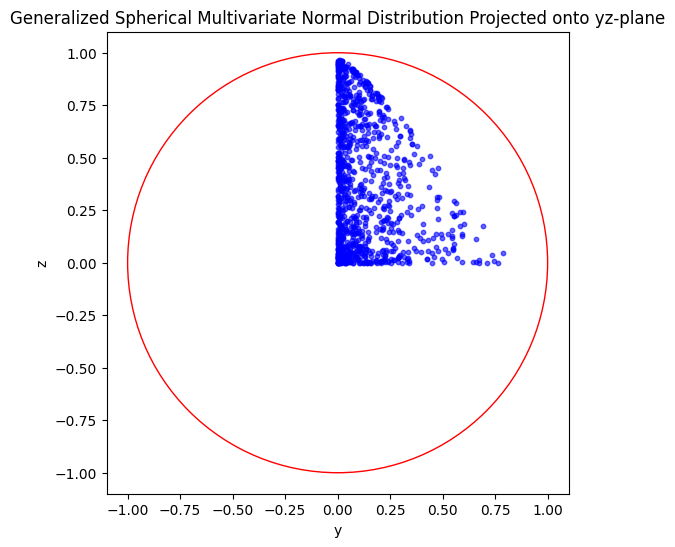

In [62]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Function to compute the logarithm map from the sphere to the tangent space
def logarithm_map(mu, x):
    """Logarithm map: Maps points from the sphere to the tangent space at mu."""
    dot_product = torch.clamp(torch.dot(mu, x), -1.0, 1.0)
    theta = torch.acos(dot_product)
    if theta == 0:
        return torch.zeros_like(x)
    return (x - mu * torch.cos(theta)) * (theta / torch.sin(theta))

# Function to compute the exponential map from the tangent space back to the sphere
def exponential_map(mu, v):
    """Exponential map: Maps points from the tangent space back to the sphere."""
    norm_v = torch.norm(v)
    if norm_v == 0:
        return mu
    return (mu * torch.cos(norm_v) + (v / norm_v) * torch.sin(norm_v)).pow(2)

# Function to sample points from a multivariate normal distribution in the tangent space
def sample_tangent_space(mu, cov, n_samples):
    """Sample from a multivariate normal distribution in the tangent space."""
    tangent_basis = torch.linalg.qr(torch.randn(len(mu), len(mu)))[0][:, 1:]  # Orthonormal basis orthogonal to mu
    distribution = torch.distributions.MultivariateNormal(torch.zeros(len(mu) - 1), cov)
    tangent_samples = distribution.sample((n_samples,))
    return tangent_samples @ tangent_basis.T  # Map samples back to the full space using tangent basis

# Normalize the points to lie on the surface of a unit sphere
# def normalize_to_sphere(samples):
#     """Normalize the sampled points to the surface of a unit sphere."""
#     norm = torch.norm(samples, dim=-1, keepdim=True)
#     return samples / norm

# Project points onto the yz-plane (if North Pole is at [1, 0, 0])
def project_onto_yz_plane(points):
    """Project points onto the yz-plane by discarding the x-coordinate."""
    return points[:, 1:]

# Parameters for multivariate normal distribution
n_samples = 1000
mu = torch.tensor([1.0, 0.0, 0.0])  # North Pole or base point on the sphere
cov = torch.tensor([[1, 0.0],  # Covariance matrix in the tangent space
                    [0.0, 0.2]])

# Sample from the multivariate normal distribution in the tangent space
tangent_samples = sample_tangent_space(mu, cov, n_samples)

# Map the points back to the sphere using the exponential map
samples_on_sphere = torch.stack([exponential_map(mu, tangent_samples[i]) for i in range(n_samples)], dim=0)

# Project the points onto the yz-plane
projected_points = project_onto_yz_plane(samples_on_sphere)

# Scatter plot of the projected points on the yz-plane
plt.figure(figsize=(6, 6))
plt.scatter(projected_points[:, 0].numpy(), projected_points[:, 1].numpy(), c='b', alpha=0.6, s=10)
plt.title('Generalized Spherical Multivariate Normal Distribution Projected onto yz-plane')
plt.xlabel('y')
plt.ylabel('z')

# Plot the unit circle boundary for reference
disk = plt.Circle((0, 0), 1, color='r', fill=False)
plt.gca().add_artist(disk)

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

Entropy of the transformed distribution: tensor(5.7218)


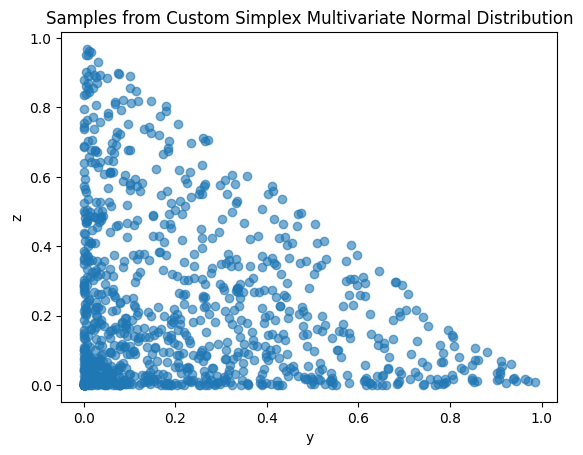

In [105]:
import torch
from torch.distributions import Transform, constraints, MultivariateNormal, Distribution

# Custom transform using the modified exponential map
class ExponentialToSimplexTransform(Transform):
    """Transform that maps points from the tangent space to the simplex."""
    domain = constraints.real_vector
    codomain = constraints.simplex
    bijective = True
    sign = +1
    
    def __init__(self, base_point):
        """
        Args:
            base_point (torch.Tensor): The base point on the sphere or simplex.
        """
        super().__init__()
        self.base_point = base_point
    
    def __call__(self, x):
        """Apply the exponential map to map from the tangent space to the simplex."""
        norm_x = torch.norm(x, dim=-1, keepdim=True)
        return (self.base_point * torch.cos(norm_x) + (x / norm_x) * torch.sin(norm_x)).pow(2)
    
    def _inverse(self, y):
        """Not implemented: Logarithm map is generally not required for the simplex."""
        raise NotImplementedError("Inverse transform (logarithm map) is not implemented.")

    def log_abs_det_jacobian(self, x, y):
        """Compute the log absolute determinant of the Jacobian."""
        norm_x = torch.norm(x, dim=-1, keepdim=True)
        sin_norm = torch.sin(norm_x).clamp(min=1e-10)
        cos_norm = torch.cos(norm_x)
        jacobian_diag = (cos_norm + (x / norm_x) * sin_norm).pow(2)
        log_det_jacobian = jacobian_diag.sum(dim=-1)
        return log_det_jacobian

# Custom distribution class
class SimplexMultivariateNormal(Distribution):
    """Custom distribution that maps a multivariate normal distribution to a simplex."""
    arg_constraints = {'loc': constraints.real_vector, 'covariance_matrix': constraints.positive_definite}
    support = constraints.simplex
    has_rsample = True

    def __init__(self, loc, covariance_matrix, validate_args=None):
        """
        Args:
            loc (torch.Tensor): Mean of the multivariate normal distribution in the tangent space.
            covariance_matrix (torch.Tensor): Covariance matrix of the distribution in the tangent space.
        """
        self.loc = loc
        self.covariance_matrix = covariance_matrix
        self.base_distribution = MultivariateNormal(loc, covariance_matrix)
        self.transform = ExponentialToSimplexTransform(loc)
        super().__init__(self.base_distribution.batch_shape, validate_args=validate_args)

    def rsample(self, sample_shape=torch.Size()):
        """Generate samples by sampling from the base distribution and applying the transform."""
        z = self.base_distribution.rsample(sample_shape)
        return self.transform(z)

    def log_prob(self, value):
        """Log-probability of a point."""
        # We need to apply the inverse transformation to map the point back to the tangent space.
        raise NotImplementedError("Inverse transformation (logarithm map) needed for log_prob.")

    def entropy(self):
        """Compute the entropy of the transformed distribution."""
        # Base distribution entropy
        base_entropy = self.base_distribution.entropy()
        
        # Monte Carlo estimate of the log-det-Jacobian expectation term
        z = self.base_distribution.sample((1000,))  # Sample from the base distribution
        transformed_z = self.transform(z)
        log_det_jacobian = self.transform.log_abs_det_jacobian(z, transformed_z)
        jacobian_term = torch.mean(log_det_jacobian)

        # Total entropy of the transformed distribution
        return base_entropy + jacobian_term

# Usage example

# Parameters for the distribution in the tangent space
loc = torch.tensor([0.0, 0.0, 0.0])  # Center in tangent space

# Create a positive definite 3x3 covariance matrix
cov = torch.tensor([[1.0, 0.3, 0.2],
                    [0.3, 1.0, 0.4],
                    [0.2, 0.4, 1.0]])  # Symmetric and positive definite

base_point = torch.tensor([1.0, 0.0, 0.0])  # Base point on the sphere (North Pole)

# Define the distribution
simplex_dist = SimplexMultivariateNormal(loc, cov)

# Sample from the distribution
samples = simplex_dist.rsample((1000,))

# Compute the entropy
entropy_value = simplex_dist.entropy()
print("Entropy of the transformed distribution:", entropy_value)

# Plot the samples on the simplex (using y and z coordinates for visualization)
import matplotlib.pyplot as plt
plt.scatter(samples[:, 1].numpy(), samples[:, 2].numpy(), alpha=0.6)
plt.title('Samples from Custom Simplex Multivariate Normal Distribution')
plt.xlabel('y')
plt.ylabel('z')
plt.show()

In [ ]:
x